In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import cohen_kappa_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torchmetrics import Accuracy, Precision
from pytorch_widedeep.initializers import KaimingNormal, XavierNormal
from pytorch_widedeep.callbacks import ModelCheckpoint, LRHistory, EarlyStopping
from pytorch_widedeep.optim import RAdam



import numpy as np
import pandas as pd
import torch

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import WidePreprocessor, TabPreprocessor
from pytorch_widedeep.models import Wide, TabMlp, WideDeep
from pytorch_widedeep.metrics import Accuracy, Recall, Precision


import pandas as pd
import numpy as np


import warnings
warnings.filterwarnings('ignore')


import numpy as np

C:\Rahul\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df_raw = pd.read_csv("cd_data_July_2021.csv")
print (df_raw.shape)
df_raw.head()

(10000, 53)


,_d_diff_ref_rend_provider,_d_more_than_one_cpt_per_claim_per_day,admission_date,age_of_patient_at_service,benefits_assignment_certification_indicator,billing_provider,billing_provider_city,billing_provider_postal_code,claim_creation_date,claim_filing_indicator_code,claim_frequency_type_code,claim_level_charge_amount,claim_submitter_id,clia_number,condition_code,days_to_claim_submission,diagnosis_count,discharge_date,drug_code_category,drug_quantity,facility_code_value,line_item_charge_amount,line_item_id,modifiers_count,ordering_provider,other_insured_group,other_payer1,other_payer2,other_subscriber1_prsn,other_subscriber2_prsn,pat_MRN,pat_relationship_wt_insured,patient_Gender,patient_PostalCode,patient_StateProvinceCode,patient_city,payer_city,payer_name,payer_postal_code,payer_state_province_code,principalDx_CCSR_Category1,prior_authorization_number,proc_hcpcs_category,procedure_modifier,referring_provider,related_causes_code,rendering_provider,service_date,service_unit_quantity,subscriber_policy_type,subscriber_prsn,supervising_provider,denialFlag
0,0,0,NaN,52.0,Y,billing_provider_0,city_92,postal_code_1050,2018-11-30,MC,1,77.68,6423,14356,NaN,5,1,NaN,Vaccine_Viral_-Influenza_A_and_B,1.0,11,44.6,6423_1,0,ordering_provider_5,NaN,NaN,NaN,NaN,NaN,11412.0,NaN,F,postal_code_765,state_15,city_92,city_16,payer_80,postal_code_98,state_15,FAC016,NaN,immunization_administration_for_vaccines/toxoids,NaN,referring_provider_4,NaN,rendering_provider_4,2018-11-25,1,NaN,P,NaN,1
1,0,0,NaN,29.0,Y,billing_provider_1,city_92,postal_code_638,2019-05-15,MC,1,382.30,17247,14356,NaN,102,4,NaN,NaN,NaN,22,133.2,17247_2,0,ordering_provider_12,NaN,NaN,NaN,NaN,NaN,13292.0,NaN,M,postal_code_1509,state_15,city_65,city_16,payer_3,postal_code_98,state_15,GEN002,NaN,Hospital_observation_services,NaN,referring_provider_4,NaN,rendering_provider_4,2019-02-03,1,NaN,P,NaN,1
2,0,0,NaN,79.0,Y,billing_provider_0,city_92,postal_code_1050,2018-07-26,MB,1,187.00,14405,14356,NaN,2,1,NaN,NaN,NaN,11,187.0,14405_1,0,ordering_provider_10,NaN,payer_53,NaN,S,NaN,13356.0,NaN,M,postal_code_407,state_15,city_71,city_41,payer_31,postal_code_54,state_1,DIG010,NaN,Office/other_outpatient_services,NaN,referring_provider_9,NaN,rendering_provider_9,2018-07-24,1,NaN,P,NaN,1
3,0,0,NaN,18.0,Y,billing_provider_0,city_92,postal_code_1412,2019-06-12,MC,1,115.00,20401,14356,NaN,3,1,NaN,NaN,NaN,11,115.0,20401_1,0,ordering_provider_5,NaN,NaN,NaN,NaN,NaN,11407.0,NaN,M,postal_code_1132,state_15,city_92,city_16,payer_3,postal_code_98,state_15,INJ041,NaN,Office/other_outpatient_services,NaN,referring_provider_4,NaN,rendering_provider_4,2019-06-09,1,NaN,P,NaN,1
4,0,0,NaN,81.0,Y,billing_provider_0,city_92,postal_code_1050,2018-02-07,MB,1,91.80,7157,14356,NaN,13,2,NaN,NaN,NaN,11,91.8,7157_1,0,ordering_provider_4,NaN,NaN,NaN,NaN,NaN,13946.0,NaN,F,postal_code_406,state_15,city_92,city_41,payer_31,postal_code_54,state_1,FAC008,NaN,Office/other_outpatient_services,NaN,referring_provider_3,NaN,rendering_provider_3,2018-01-25,1,NaN,P,NaN,1


In [3]:
def missing_zero_values_table(df):
#         zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

### Explicit data type conversion

In [4]:
intTypeList =["age_of_patient_at_service",
#                 "claim_level_charge_amount",
                "days_to_claim_submission",
                "diagnosis_count",
                "drug_quantity",
                "line_item_charge_amount",
                "modifiers_count",
                "service_unit_quantity", 
              "claim_level_charge_amount"]

# floatTypeList = [ "claim_level_charge_amount"]


strTypeList = ["billing_provider",
                "billing_provider_city",
                "billing_provider_postal_code",
                "claim_submitter_id",
                "clia_number",
                "line_item_id",
                "ordering_provider",
                "pat_MRN",
                "patient_StateProvinceCode",
                "patient_city",
                "payer_city",
                "payer_name",
                "payer_postal_code",
                "payer_state_province_code",
                "prior_authorization_number",
                "referring_provider",
                "rendering_provider",
                "supervising_provider",
                "_d_diff_ref_rend_provider",
                "_d_more_than_one_cpt_per_claim_per_day",
                "benefits_assignment_certification_indicator",
                "claim_filing_indicator_code",
                "claim_frequency_type_code",
                "condition_code",
                "drug_code_category",
                "facility_code_value",
                "other_insured_group",
                "other_payer1",
                "other_payer2",
                "other_subscriber1_prsn",
                "other_subscriber2_prsn",
                "pat_relationship_wt_insured",
                "patient_Gender",
                "patient_PostalCode",
                "principalDx_CCSR_Category1",
                "proc_hcpcs_category",
                "procedure_modifier",
                "related_causes_code",
                "subscriber_policy_type",
                "subscriber_prsn",
                "denialFlag"
                ]

dataTypeList = ["admission_date",
                "claim_creation_date",
                "discharge_date",
                "service_date"]

# print (len(intTypeList) +  len(strTypeList) + len(dataTypeList))

df_raw[intTypeList] = df_raw[intTypeList].apply(pd.to_numeric, errors='coerce')
df_raw[strTypeList] = df_raw[strTypeList].astype(object)

for i in range(len(dataTypeList)):
    df_raw[dataTypeList[i]] = pd.to_datetime(df_raw[dataTypeList[i]], format="%Y-%m-%d")


#### Droping the missing columns that having more or equal to 75% 

In [5]:
# Delete columns containing either 80% or more than 80% NaN Values
perc = 80
min_count =  int(((100-perc)/100)*df_raw.shape[0] + 1)
mod_df = df_raw.dropna( axis=1, thresh=min_count)
mod_df.shape


(10000, 40)

In [6]:
# Integer Columns

temp = list(set(intTypeList).difference(set(mod_df.columns.tolist())))
print ("columns removed = ", temp)
for i in range(len(temp)):
    intTypeList.remove(temp[i])
    
int_df = mod_df[intTypeList]

# print (int_df.shape)

# https://integrisok.com/resources/on-your-health/2015/october/stages-of-life-health-for-every-age
int_df["age_of_patient_Group_customize"] = pd.cut(int_df["age_of_patient_at_service"],\
                 [-1, 1, 4, 12, 19, 39, 59, np.inf],\
                 labels=['Infant', 'Toddler', 'Child', 'Teen', 'Adult', 'Middle Age Adult', 'Senior Adult'])

scaler = StandardScaler()
scaler.fit(int_df.drop(["age_of_patient_Group_customize"], axis = 1))
scaled_features = scaler.transform(int_df.drop(["age_of_patient_Group_customize"], axis = 1))
scaled_features_df = pd.DataFrame(scaled_features,columns=int_df.drop(["age_of_patient_Group_customize"], axis = 1).columns)
scaled_features_df["age_of_patient_Group_customize"] = int_df[["age_of_patient_Group_customize"]]

int_df = scaled_features_df.copy(deep = True)

print (int_df.shape)
int_df.head()

columns removed =  ['drug_quantity']
(10000, 8)


,age_of_patient_at_service,days_to_claim_submission,diagnosis_count,line_item_charge_amount,modifiers_count,service_unit_quantity,claim_level_charge_amount,age_of_patient_Group_customize
0,0.296679,-0.533557,-0.791473,-0.338453,-0.160897,-0.014581,-0.410676,Middle Age Adult
1,-0.419674,0.328220,0.417129,-0.166447,-0.160897,-0.014581,-0.001567,Adult
2,1.137615,-0.560210,-0.791473,-0.062002,-0.160897,-0.014581,-0.263858,Senior Adult
3,-0.762277,-0.551326,-0.791473,-0.201781,-0.160897,-0.014581,-0.360555,Teen
4,1.199907,-0.462483,-0.388606,-0.246820,-0.160897,-0.014581,-0.391713,Senior Adult


In [7]:
# dates Columns

temp = list(set(dataTypeList).difference(set(mod_df.columns.tolist())))
print ("columns removed = ",temp)
for i in range(len(temp)):
    dataTypeList.remove(temp[i])
    
dates_df =  mod_df[dataTypeList]

dates_df["serviceToClaimDays"] = (dates_df['claim_creation_date'] - dates_df['service_date']).dt.days

# Assumption

temp = dates_df[dates_df["serviceToClaimDays"] > 365]
# print (temp.shape)
# print (temp["serviceToClaimDays"].min())
# print (temp["serviceToClaimDays"].max())

# print (dates_df.shape)


scaler = StandardScaler()
scaler.fit(dates_df[["serviceToClaimDays"]] )
scaled_features = scaler.transform(dates_df[["serviceToClaimDays"]] )
dates_df["serviceToClaimDays"] = scaled_features
dates_df.head()


columns removed =  ['discharge_date', 'admission_date']


,claim_creation_date,service_date,serviceToClaimDays
0,2018-11-30,2018-11-25,-0.496758
1,2019-05-15,2019-02-03,0.496367
2,2018-07-26,2018-07-24,-0.527793
3,2019-06-12,2019-06-09,-0.517448
4,2018-02-07,2018-01-25,-0.413998


In [8]:
# Categorical Columns

temp = list(set(strTypeList).difference(set(mod_df.columns.tolist())))
print ("columns removed = ",temp)
for i in range(len(temp)):
    strTypeList.remove(temp[i])
    
    
str_df =  mod_df[strTypeList]
columns_drop_list = ["billing_provider_city", "claim_submitter_id", "clia_number", "line_item_id", "pat_MRN"]
#                      "other_payer2" ]


str_df.drop(columns_drop_list, inplace = True, axis = 1)

str_df = str_df.fillna(value="Unknown")

print (str_df.shape)
str_df.head()

columns removed =  ['other_payer2', 'related_causes_code', 'condition_code', 'subscriber_policy_type', 'drug_code_category', 'supervising_provider', 'prior_authorization_number', 'other_insured_group', 'pat_relationship_wt_insured', 'other_subscriber2_prsn']
(10000, 26)


,billing_provider,billing_provider_postal_code,ordering_provider,patient_StateProvinceCode,patient_city,payer_city,payer_name,payer_postal_code,payer_state_province_code,referring_provider,rendering_provider,_d_diff_ref_rend_provider,_d_more_than_one_cpt_per_claim_per_day,benefits_assignment_certification_indicator,claim_filing_indicator_code,claim_frequency_type_code,facility_code_value,other_payer1,other_subscriber1_prsn,patient_Gender,patient_PostalCode,principalDx_CCSR_Category1,proc_hcpcs_category,procedure_modifier,subscriber_prsn,denialFlag
0,billing_provider_0,postal_code_1050,ordering_provider_5,state_15,city_92,city_16,payer_80,postal_code_98,state_15,referring_provider_4,rendering_provider_4,0,0,Y,MC,1,11,Unknown,Unknown,F,postal_code_765,FAC016,immunization_administration_for_vaccines/toxoids,Unknown,P,1
1,billing_provider_1,postal_code_638,ordering_provider_12,state_15,city_65,city_16,payer_3,postal_code_98,state_15,referring_provider_4,rendering_provider_4,0,0,Y,MC,1,22,Unknown,Unknown,M,postal_code_1509,GEN002,Hospital_observation_services,Unknown,P,1
2,billing_provider_0,postal_code_1050,ordering_provider_10,state_15,city_71,city_41,payer_31,postal_code_54,state_1,referring_provider_9,rendering_provider_9,0,0,Y,MB,1,11,payer_53,S,M,postal_code_407,DIG010,Office/other_outpatient_services,Unknown,P,1
3,billing_provider_0,postal_code_1412,ordering_provider_5,state_15,city_92,city_16,payer_3,postal_code_98,state_15,referring_provider_4,rendering_provider_4,0,0,Y,MC,1,11,Unknown,Unknown,M,postal_code_1132,INJ041,Office/other_outpatient_services,Unknown,P,1
4,billing_provider_0,postal_code_1050,ordering_provider_4,state_15,city_92,city_41,payer_31,postal_code_54,state_1,referring_provider_3,rendering_provider_3,0,0,Y,MB,1,11,Unknown,Unknown,F,postal_code_406,FAC008,Office/other_outpatient_services,Unknown,P,1


In [9]:
missing_zero_values_table(str_df)

Your selected dataframe has 26 columns and 10000 Rows.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Data Type


In [10]:
colNames = list(str_df.columns)
tempDummy = str_df.copy()

In [11]:
final_data = pd.concat([int_df, dates_df, tempDummy], axis = 1)
final_data["denialFlag"] = final_data["denialFlag"].astype(int)


In [12]:
final_data["denialFlag"].value_counts()/len(final_data) *100

0    70.0
1    30.0
Name: denialFlag, dtype: float64

In [13]:
final_data_0 = final_data[final_data["denialFlag"]==0]
final_data_1 = final_data[final_data["denialFlag"]==1]

In [14]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split( final_data_0.loc[:, ~final_data_0.columns.isin(['denialFlag'])],\
                                                    final_data_0["denialFlag"], test_size=0.30, random_state=42)

# print (X_train_0.shape[0] )
# print (X_test_0.shape[0] )

# print (X_train_0.shape[0] + X_test_0.shape[0])
# print (y_train_0.shape[0] + y_test_0.shape[0])

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split( final_data_1.loc[:, ~final_data_1.columns.isin(['denialFlag'])],\
                                                    final_data_1["denialFlag"], test_size=0.10, random_state=42)
# print (X_train_1.shape[0] )
# print (X_test_1.shape[0] )

# print (X_train_1.shape[0] + X_test_1.shape[0])
# print (y_train_1.shape[0] + y_test_1.shape[0])


# Test and Validation data set
X_test_0, X_val_0, y_test_0, y_val_0 = train_test_split( X_test_0, y_test_0, test_size=0.10, random_state=42)
# print (X_val_0.shape[0])
# print (X_test_0.shape[0])
# print (X_val_0.shape[0] + X_test_0.shape[0])

##############################
X_test_1, X_val_1, y_test_1, y_val_1 = train_test_split( X_test_1, y_test_1, test_size=0.10, random_state=42)
# print (X_val_1.shape[0])
# print (X_test_1.shape[0])
# print (X_val_1.shape[0] + X_test_1.shape[0])

trainData_0 = pd.concat([X_train_0, y_train_0], axis = 1)
trainData_1 = pd.concat([X_train_1, y_train_1], axis = 1)
trainData = pd.concat([trainData_0, trainData_1], axis = 0)
# trainData.shape

testData_0 = pd.concat([X_test_0, y_test_0], axis = 1)
testData_1 = pd.concat([X_test_1, y_test_1], axis = 1)
testData = pd.concat([testData_0, testData_1], axis = 0)
# testData.shape


valData_0 = pd.concat([X_val_0, y_val_0], axis = 1)
valData_1 = pd.concat([X_val_1, y_val_1], axis = 1)
valData = pd.concat([valData_0, valData_1], axis = 0)
# valData.shape

# trainData.shape[0] + testData.shape[0] + valData.shape[0]

trainData_0 = pd.concat([X_train_0, y_train_0], axis = 1)
trainData_1 = pd.concat([X_train_1, y_train_1], axis = 1)
trainData = pd.concat([trainData_0, trainData_1], axis = 0)

df_train = trainData.drop(["denialFlag"], axis = 1)
trainData.shape

(7600, 37)

In [15]:
testData_0 = pd.concat([X_test_0, y_test_0], axis = 1)
testData_1 = pd.concat([X_test_1, y_test_1], axis = 1)
testData = pd.concat([testData_0, testData_1], axis = 0)
testData.shape

(2160, 37)

In [16]:
valData_0 = pd.concat([X_val_0, y_val_0], axis = 1)
valData_1 = pd.concat([X_val_1, y_val_1], axis = 1)
valData = pd.concat([valData_0, valData_1], axis = 0)
valData.shape

(240, 37)

In [17]:
trainData.shape[0] + testData.shape[0] + valData.shape[0]

10000

In [18]:
trainData["denialFlag"].value_counts()/len(trainData) *100

0    64.473684
1    35.526316
Name: denialFlag, dtype: float64

In [19]:
# prepare wide, crossed, embedding and continuous columns
wide_cols = str_df.drop(["denialFlag"], axis = 1).columns.tolist()

cross_cols = [("age_of_patient_at_service", "payer_postal_code"), ("patient_PostalCode", "procedure_modifier")]

embed_cols = [
    ("ordering_provider", 16),
    ("patient_city", 16),
    ("payer_city", 32),
    ("payer_name", 32),
    ("payer_postal_code", 32),
    ("payer_state_province_code", 16),
    ("referring_provider", 32),
    ("rendering_provider", 32),
    ("claim_filing_indicator_code", 32),    
    ("facility_code_value", 32),        
    ("other_payer1", 32),    
    ("patient_PostalCode", 32),    
    ("principalDx_CCSR_Category1", 64),    
    ("proc_hcpcs_category", 64),    
    ("procedure_modifier", 64),             
]

cont_cols = ["age_of_patient_at_service",
             "days_to_claim_submission", 
             "diagnosis_count",
             "line_item_charge_amount",
             "modifiers_count",
             "service_unit_quantity",
             "claim_level_charge_amount",
            ]


target_col = "denialFlag"

# target
target = trainData["denialFlag"].values

In [20]:
trainData[wide_cols].head()

,billing_provider,billing_provider_postal_code,ordering_provider,patient_StateProvinceCode,patient_city,payer_city,payer_name,payer_postal_code,payer_state_province_code,referring_provider,rendering_provider,_d_diff_ref_rend_provider,_d_more_than_one_cpt_per_claim_per_day,benefits_assignment_certification_indicator,claim_filing_indicator_code,claim_frequency_type_code,facility_code_value,other_payer1,other_subscriber1_prsn,patient_Gender,patient_PostalCode,principalDx_CCSR_Category1,proc_hcpcs_category,procedure_modifier,subscriber_prsn
4612,billing_provider_1,postal_code_638,ordering_provider_12,state_15,city_92,city_41,payer_31,postal_code_54,state_1,referring_provider_2,rendering_provider_2,0,0,Y,MB,1,23,payer_80,S,F,postal_code_35,SYM004,Emergency_department_services,Unknown,P
3978,billing_provider_1,postal_code_638,ordering_provider_21,state_15,city_92,city_16,payer_80,postal_code_98,state_15,referring_provider_19,rendering_provider_20,0,0,Y,MC,1,22,Unknown,Unknown,M,postal_code_193,MBD012,Hospital_observation_services,Unknown,P
6050,billing_provider_0,postal_code_1412,ordering_provider_5,state_15,city_92,city_16,payer_3,postal_code_98,state_15,referring_provider_4,rendering_provider_4,0,0,Y,MC,1,11,Unknown,Unknown,F,postal_code_631,FAC014,Preventive_medicine_services,Unknown,P
7960,billing_provider_0,postal_code_1050,ordering_provider_14,state_15,city_71,city_41,payer_31,postal_code_54,state_1,referring_provider_13,rendering_provider_13,0,0,Y,MB,1,11,payer_96,S,M,postal_code_729,MUS025,Office/other_outpatient_services,25,P
5548,billing_provider_0,postal_code_1050,ordering_provider_1,state_15,city_71,city_41,payer_31,postal_code_54,state_1,referring_provider_1,rendering_provider_1,0,0,Y,MB,1,11,payer_96,S,M,postal_code_78,FAC014,pulmonary,Unknown,P


In [21]:
# wide
wide_preprocessor = WidePreprocessor(wide_cols=wide_cols, crossed_cols=cross_cols)
X_wide = wide_preprocessor.fit_transform(df_train)
wide = Wide(wide_dim=np.unique(X_wide).shape[0], pred_dim=1)


# deeptabular

tab_preprocessor = TabPreprocessor(embed_cols=embed_cols, continuous_cols=cont_cols)
X_tab = tab_preprocessor.fit_transform(df_train)
deeptabular = TabMlp(
    mlp_hidden_dims=[64, 32],
    column_idx=tab_preprocessor.column_idx,
    embed_input=tab_preprocessor.embeddings_input,
    continuous_cols=cont_cols,
)

# wide and deep
model = WideDeep(wide=wide, deeptabular=deeptabular)

In [22]:
model

WideDeep(
  (wide): Wide(
    (wide_linear): Embedding(4478, 1, padding_idx=0)
  )
  (deeptabular): Sequential(
    (0): TabMlp(
      (embed_layers): ModuleDict(
        (emb_layer_ordering_provider): Embedding(37, 16, padding_idx=0)
        (emb_layer_patient_city): Embedding(64, 16, padding_idx=0)
        (emb_layer_payer_city): Embedding(15, 32, padding_idx=0)
        (emb_layer_payer_name): Embedding(28, 32, padding_idx=0)
        (emb_layer_payer_postal_code): Embedding(23, 32, padding_idx=0)
        (emb_layer_payer_state_province_code): Embedding(11, 16, padding_idx=0)
        (emb_layer_referring_provider): Embedding(38, 32, padding_idx=0)
        (emb_layer_rendering_provider): Embedding(39, 32, padding_idx=0)
        (emb_layer_claim_filing_indicator_code): Embedding(6, 32, padding_idx=0)
        (emb_layer_facility_code_value): Embedding(11, 32, padding_idx=0)
        (emb_layer_other_payer1): Embedding(83, 32, padding_idx=0)
        (emb_layer_patient_PostalCode): Embeddin

In [37]:
wide_opt = torch.optim.Adam(model.wide.parameters(), lr=0.03)
deep_opt = RAdam(model.deeptabular.parameters(), lr=0.01)
# deep_opt = ranger21.Ranger21(model.deeptabular.parameters(), lr=0.01)

# LR Schedulers
wide_sch = torch.optim.lr_scheduler.StepLR(wide_opt, step_size=3)
deep_sch = torch.optim.lr_scheduler.StepLR(deep_opt, step_size=5)

# Component-dependent settings as Dict
optimizers = {'wide': wide_opt, 'deeptabular':deep_opt}
schedulers = {'wide': wide_sch, 'deeptabular':deep_sch}
initializers = {'wide': KaimingNormal, 'deeptabular':XavierNormal}
# General settings as List
callbacks = [LRHistory(n_epochs=10), EarlyStopping, ModelCheckpoint(filepath='model_weights/wd_outv2')]
# metrics = [Accuracy, Precision]
metrics = [Accuracy]

In [38]:
trainer = Trainer(model, 
                  objective='binary', 
                  optimizers=optimizers, 
                  lr_schedulers=schedulers,
                  initializers=initializers,
                  callbacks=callbacks,
                  metrics=metrics
#                   ,
#                   seed=15
                 )

In [39]:
# accuracy = Accuracy(average=None, num_classes=2)
# precision = Precision(average='micro', num_classes=2)

# trainer = Trainer(model, objective="binary", metrics=[accuracy, precision])

# trainer = Trainer(model, objective="binary", metrics=[Accuracy])
trainer.fit(
    X_wide=X_wide,
    X_tab=X_tab,
    target=target,
    n_epochs=200,
    batch_size=256,
    val_split=0.1,
)

valid: 100%|████████████████████████████████████████| 3/3 [00:36<00:00, 12.10s/it, loss=0.588, metrics={'acc': 0.8053}]


Model weights after training corresponds to the those of the final epoch which might not be the best performing weights. Usethe 'ModelCheckpoint' Callback to restore the best epoch weights.


In [40]:
print(trainer.history)
print(trainer.lr_history)

{'train_loss': [1.3333391790036802, 0.831428278375555, 0.5694827812689321, 0.4316196044286092, 0.3745325682339845, 0.33295624565195153, 0.3200574108847865, 0.31530565906454017, 0.3093675049366774, 0.3085276495527338, 0.2994479812957622, 0.3072867156178863, 0.29988369511233437, 0.30105019719512377, 0.2996861890510277, 0.3019120135792979], 'train_acc': [0.5967836257309942, 0.6714912280701755, 0.7567251461988304, 0.8119883040935673, 0.8365497076023392, 0.8517543859649123, 0.8570175438596491, 0.8599415204678362, 0.8616959064327485, 0.8628654970760234, 0.8652046783625731, 0.8616959064327485, 0.8676900584795322, 0.8671052631578947, 0.8681286549707602, 0.8669590643274854], 'val_loss': [1.0722954670588176, 0.76329106092453, 0.6157670617103577, 0.5921811858812968, 0.5892714858055115, 0.5826715628306071, 0.5847233533859253, 0.5851366718610128, 0.583315352598826, 0.5839397311210632, 0.5863945682843527, 0.5874273180961609, 0.588054895401001, 0.5884934465090433, 0.5881805817286173, 0.58827386299769

In [41]:
from matplotlib import pyplot as plt


In [42]:
# trainer.history["train_loss"]

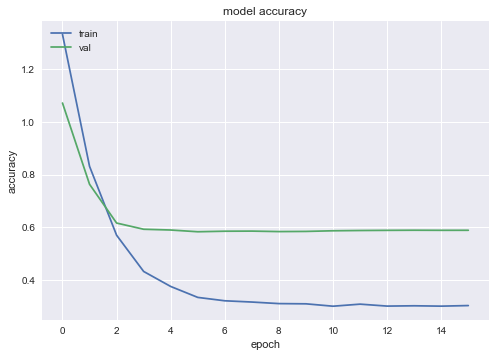

In [43]:
plt.plot(trainer.history['train_loss'])
plt.plot(trainer.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
# predict test
X_wide_train = wide_preprocessor.transform(trainData.drop(["denialFlag"], axis = 1))
X_tab_train = tab_preprocessor.transform(trainData.drop(["denialFlag"], axis = 1))
preds_train = trainer.predict_proba(X_wide=X_wide_train, X_tab=X_tab_train)

# predict test
X_wide_te = wide_preprocessor.transform(testData.drop(["denialFlag"], axis = 1))
X_tab_te = tab_preprocessor.transform(testData.drop(["denialFlag"], axis = 1))
preds_test = trainer.predict_proba(X_wide=X_wide_te, X_tab=X_tab_te)

# predict test
X_wide_ve = wide_preprocessor.transform(valData.drop(["denialFlag"], axis = 1))
X_tab_ve = tab_preprocessor.transform(valData.drop(["denialFlag"], axis = 1))
preds_val = trainer.predict_proba(X_wide=X_wide_ve, X_tab=X_tab_ve)

predict: 100%|███████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


In [45]:
def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value
        
    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [46]:
# Add prediction probability to dataframe
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python#:~:text=Python%20code%3A&text=The%20optimal%20cut%20off%20point%20is%200.317628%2C%20so%20anything%20above,zero%20in%20the%20current%20example.
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


data = trainData.copy()
# rf_probs_list = model._proba(data.drop(['denialFlag'], axis = 1))

rf_probs = preds_train[:, 1]

fpr, tpr, thresholds =roc_curve(data['denialFlag'], rf_probs)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

threshold = Find_Optimal_Cutoff(data['denialFlag'], rf_probs)
print (threshold)

##########
data["pred_proba"] = rf_probs
data['pred'] = [1 if x > threshold[0] else 0 for x in data['pred_proba']]


# evaluate predictions
accuracy = accuracy_score(data["denialFlag"], data["pred"])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(precision_score(data["denialFlag"], data["pred"], average="macro"))
print(recall_score(data["denialFlag"], data["pred"], average="macro")) 
print(f1_score(data["denialFlag"], data["pred"], average="macro"))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(data['denialFlag'], data['pred'])


Area under the ROC curve : 0.937796
[0.34634339809417725]
Accuracy: 86.80%
0.8532253265225584
0.8679705215419501
0.8591190051304538


array([[4254,  646],
       [ 357, 2343]], dtype=int64)

### Test dataset 

In [47]:
# Add prediction probability to dataframe
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python#:~:text=Python%20code%3A&text=The%20optimal%20cut%20off%20point%20is%200.317628%2C%20so%20anything%20above,zero%20in%20the%20current%20example.
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

data = testData.copy()
# rf_probs_list = model.predict_proba(data.drop(['denialFlag'], axis = 1))

rf_probs = preds_test[:, 1]


fpr, tpr, thresholds =roc_curve(data['denialFlag'], rf_probs)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

threshold = Find_Optimal_Cutoff(data['denialFlag'], rf_probs)
print (threshold)

##########
data["pred_proba"] = rf_probs
data['pred'] = [1 if x > threshold[0] else 0 for x in data['pred_proba']]


# evaluate predictions
accuracy = accuracy_score(data["denialFlag"], data["pred"])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print("precision_score = ", precision_score(data["denialFlag"], data["pred"], average="micro"))
print("recall_score", recall_score(data["denialFlag"], data["pred"], average="micro")) 
print("f1_score", f1_score(data["denialFlag"], data["pred"], average="micro"))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(data['denialFlag'], data['pred'])

print ("cohen_kappa_score = ", cohen_kappa_score(data["denialFlag"], data["pred"]))


Area under the ROC curve : 0.861358
[0.35675838589668274]
Accuracy: 78.43%
precision_score =  0.7842592592592592
recall_score 0.7842592592592592
f1_score 0.7842592592592592
cohen_kappa_score =  0.36338797814207646


0.8613580246913579


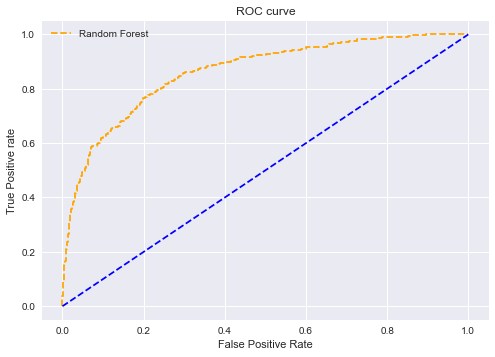

In [48]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(data["denialFlag"], rf_probs, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(data["denialFlag"]))]
p_fpr, p_tpr, _ = roc_curve(data["denialFlag"], random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(data["denialFlag"], rf_probs)

print(auc_score1)


import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

### Validation dataset

In [49]:
# Add prediction probability to dataframe
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python#:~:text=Python%20code%3A&text=The%20optimal%20cut%20off%20point%20is%200.317628%2C%20so%20anything%20above,zero%20in%20the%20current%20example.
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


data = valData.copy()
# rf_probs_list = model.predict_proba(data.drop(['denialFlag'], axis = 1))

rf_probs = preds_val[:, 1]


fpr, tpr, thresholds =roc_curve(data['denialFlag'], rf_probs)
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

# threshold = Find_Optimal_Cutoff(data['denialFlag'], rf_probs)
print (threshold)

##########
data["pred_proba"] = rf_probs
data['pred'] = [1 if x > threshold[0] else 0 for x in data['pred_proba']]


# evaluate predictions
accuracy = accuracy_score(data["denialFlag"], data["pred"])
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print("precision_score = ", precision_score(data["denialFlag"], data["pred"], average="micro"))
print("recall_score", recall_score(data["denialFlag"], data["pred"], average="micro")) 
print("f1_score", f1_score(data["denialFlag"], data["pred"], average="micro"))

# Print confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(data['denialFlag'], data['pred'])

print ("cohen_kappa_score = ", cohen_kappa_score(data["denialFlag"], data["pred"]))


Area under the ROC curve : 0.818413
[0.35675838589668274]
Accuracy: 76.25%
precision_score =  0.7625
recall_score 0.7625
f1_score 0.7625
cohen_kappa_score =  0.3027522935779816


0.8184126984126985


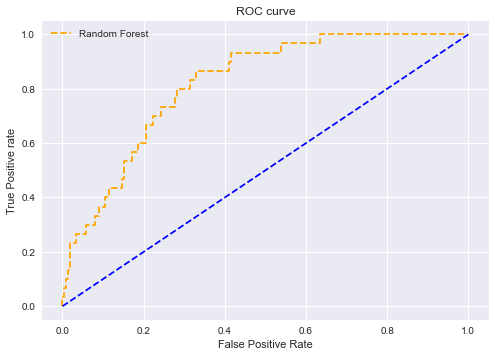

In [50]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(data["denialFlag"], rf_probs, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(data["denialFlag"]))]
p_fpr, p_tpr, _ = roc_curve(data["denialFlag"], random_probs, pos_label=1)

from sklearn.metrics import roc_auc_score

# auc scores
auc_score1 = roc_auc_score(data["denialFlag"], rf_probs)

print(auc_score1)


import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();